# Lab 4: Basic text preprocessing and topic modeling

The goal of this assignment is to get familiar with textual data analysis.


**Submission: submit via onq.** 


In [ ]:
# Import needed libraries. E.g., pandas, sklearn, nltk, etc. 
import pandas as pd
import sklearn
import nltk
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem import WordNetLemmatizer
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Task 1: The given dataset is a table containing questions about R on StackOverflow site. Your first task is to perform standard text prepossessing steps introduced in lectures for future tasks. You can perform analysis on title or body of the questions.

note you can the dataset on:- https://www.kaggle.com/datasets/stackoverflow/rquestions

In [ ]:
# TODO code for task 1
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/Colab Notebooks/Datasets/Questions.csv.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('/content/drive/MyDrive/Colab Notebooks/Datasets')

dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/Questions.csv")
dataset.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,77434,14008.0,2008-09-16T21:40:29Z,171,How to access the last value in a vector?,<p>Suppose I have a vector that is nested in a...
1,79709,NaN,2008-09-17T03:39:16Z,3,Worse sin: side effects or passing massive obj...,<p>I have a function inside a loop inside a fu...
2,95007,15842.0,2008-09-18T17:59:19Z,56,Explain the quantile() function in R,<p>I've been mystified by the R quantile funct...
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,<p>How can I test for the <code>EOF</code> fla...
4,255697,1941213.0,2008-11-01T15:48:30Z,4,Is there an R package for learning a Dirichlet...,<p>I'm looking for a an <code>R</code> package...


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE) #match one or more white sepace
    RE_TAGS = re.compile(r"<.*?>") #match <any num of words>
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž0-9]+", re.IGNORECASE) #match any English word
    RE_SINGLECHAR = re.compile(r"\b^[^A-Za-zÀ-ž0-9]+\b", re.IGNORECASE) #match any word with word boundary.
    text = re.sub(RE_TAGS, " ", text) #remove one or more white sepace
    text = re.sub(RE_ASCII, " ", text) #remove <any num of words>
    text = re.sub(RE_SINGLECHAR, " ", text) #remove any English word
    text = re.sub(RE_WSPACE, " ", text) #remove any word with word boundary.
    word_tokens = word_tokenize(text)

    words_tokens_lower = [word.lower() for word in word_tokens]
    words_filtered = [lemmatizer.lemmatize(word) for word in words_tokens_lower if word not in stop_words]
    
    clean_text = words_filtered
    return clean_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
dataset["Title"] = dataset.loc[dataset["Title"].str.len() > 10, "Title"]
clean_text = dataset["Title"].map(lambda x: clean_text(x) if isinstance(x, str) else x).copy() ## clean and lemmatize dataset

In [ ]:
clean_text.head()

0                        [access, last, value, vector]
1    [worse, sin, side, effect, passing, massive, o...
2                     [explain, quantile, function, r]
3                                 [test, eof, flag, r]
4    [r, package, learning, dirichlet, prior, count...
Name: Title, dtype: object

Task 2: Using existing libraries, such as gensim https://radimrehurek.com/gensim/ to learn word embeddings from the prepossessed text from previous step. At the end of this step, you should save the learned word embeddings in a file.

In [ ]:
# TODO code for task 2
#Applying word embeddings
from gensim.corpora import Dictionary

id2word = Dictionary(clean_text)

# Create Corpus
texts = clean_text

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [ ]:
#readable bag of words
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('access', 1), ('last', 1), ('value', 1), ('vector', 1)]]

Task 3: Perform topic analysis on the prepossessed textual data. Briefly specify how you pick the number of topics. 

Present your findings (the final set of topics you extracted, the popularity of each topic). 

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) using loop and pick the one that gives the highest coherence value and the least log preplexity score.


In [ ]:
# TODO code for task 3, hint, popularity of each topic is the ratio of documents discussing one topic, you need to read the topic assignment for each document and then calculate this value.
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
log_perplexity_list = []
coherence_model_list = []
for i in tqdm(range(2, 20)):
    lda_model = LdaModel(corpus=corpus,id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=1,
                                           alpha='auto',
                                           per_word_topics=True)
    log_perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=clean_text, dictionary=id2word, coherence='c_v')
    log_perplexity_list.append(log_perplexity)
    coherence_model_list.append(coherence_model_lda.get_coherence())

  0%|          | 0/18 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

Choose best K

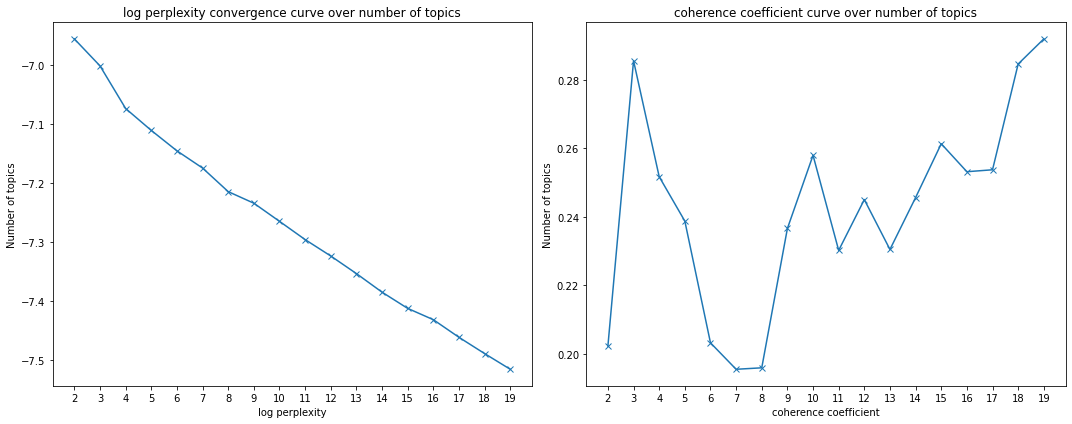

In [ ]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(1, 2, 1) 
ax2 = fig.add_subplot(1, 2, 2) 

ax1.plot(np.arange(2,20), log_perplexity_list,marker = 'x')
ax1.set_title('log perplexity convergence curve over number of topics')
ax1.set_xlabel('log perplexity')
ax1.set_ylabel('Number of topics')

ax1.set_xticks(np.arange(2,20)) 
#ax.set_xticklabels([1,4,5], fontsize=12)

ax2.plot(np.arange(2,20), coherence_model_list,marker = 'x')
ax2.set_title('coherence coefficient curve over number of topics')
ax2.set_xlabel('coherence coefficient')
ax2.set_ylabel('Number of topics')

ax2.set_xticks(np.arange(2,20)) 

#ax1.title.set_text('First Plot')
#ax2.title.set_text('Second Plot')

plt.tight_layout()
plt.show()

Rebulid LDA model using the optimal k value

In [ ]:
lda_model = LdaModel(corpus=corpus,id2word=id2word,num_topics=19, 
                    random_state=100,
                    update_every=1,
                    chunksize=100,
                    passes=1,
                    alpha='auto',
                    per_word_topics=True)
coherence_model_lda = CoherenceModel(model=lda_model, texts=clean_text, dictionary=id2word, coherence='c_v')

print(f"log_perplexity value when k 19 = is:{lda_model.log_perplexity(corpus)}")
print(f"Coherence value when k 19 = is:{coherence_model_lda.get_coherence()}")

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

log_perplexity value when k 19 = is:-7.51503481942017
Coherence value when k 19 = is:0.2919636636744609


In [ ]:
pprint(lda_model.print_topics())

[(0,
  '0.235*"column" + 0.121*"row" + 0.093*"datafram" + 0.068*"name" + '
  '0.068*"base" + 0.055*"date" + 0.049*"one" + 0.031*"anoth" + 0.022*"size" + '
  '0.019*"split"'),
 (1,
  '0.267*"function" + 0.079*"chang" + 0.060*"add" + 0.052*"point" + '
  '0.049*"color" + 0.031*"show" + 0.027*"import" + 0.026*"insid" + 0.024*"pdf" '
  '+ 0.019*"imag"'),
 (2,
  '0.135*"shini" + 0.133*"multipl" + 0.115*"creat" + 0.066*"condit" + '
  '0.054*"find" + 0.036*"regress" + 0.021*"singl" + 0.018*"unabl" + '
  '0.017*"linear" + 0.015*"analysi"'),
 (3,
  '0.138*"group" + 0.084*"calcul" + 0.068*"subset" + 0.062*"specif" + '
  '0.055*"format" + 0.033*"non" + 0.025*"summari" + 0.021*"give" + '
  '0.019*"year" + 0.019*"averag"'),
 (4,
  '0.095*"x" + 0.091*"set" + 0.083*"label" + 0.076*"axi" + 0.073*"read" + '
  '0.044*"write" + 0.024*"given" + 0.020*"rvest" + 0.020*"instead" + '
  '0.016*"limit"'),
 (5,
  '0.458*"r" + 0.139*"use" + 0.093*"valu" + 0.049*"packag" + 0.045*"file" + '
  '0.021*"line" + 0.020*"

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.437518  0.125487       1        1  14.705483
17    -0.088662 -0.442528       2        1   7.245174
6     -0.050284 -0.027856       3        1   6.909970
18    -0.001928  0.026820       4        1   5.848610
13     0.010947  0.020630       5        1   5.365438
8      0.008503  0.015149       6        1   5.238941
11     0.011674 -0.005336       7        1   5.237293
2      0.027388  0.008879       8        1   4.955216
15     0.021640 -0.000068       9        1   4.876238
4      0.034672  0.033608      10        1   4.778331
9      0.037292  0.025425      11        1   4.293746
1      0.040339  0.037064      12        1   4.144077
14     0.043883  0.026401      13        1   4.011375
3      0.042640  0.024218      14        1   3.985019
12     0.057292  0.033221      15        1   3.870428
16     0.058421  0.029394      16        1   3.849052
5      0.056501  0.028120      17        1   3.831566
10     0.056177  0.010974      18        1   3.648637
0      0.071023  0.030398      19        1   3.205408, topic_info=          Term          Freq         Total Category  logprob  loglift
14           r  85645.000000  85645.000000  Default  30.0000  30.0000
19        data  27057.000000  27057.000000  Default  29.0000  29.0000
79      column  19681.000000  19681.000000  Default  28.0000  28.0000
105      using  19765.000000  19765.000000  Default  27.0000  27.0000
12    function  15136.000000  15136.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
2578  starting    267.852612    268.743010  Topic19  -4.9442   3.4370
3343       pca    260.718795    261.609192  Topic19  -4.9712   3.4369
5244    either    250.465310    251.355708  Topic19  -5.0113   3.4368
3212  corrplot    249.943665    250.834062  Topic19  -5.0134   3.4368
859   equation    249.384765    250.275162  Topic19  -5.0156   3.4368

[604 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
823      11  0.999695     0
662      11  0.999669     1
460       4  0.999572     2
844       8  0.999653     3
928      12  0.998622    3d
...     ...       ...   ...
65        6  0.999620     x
3840     17  0.998111  xlsx
484       8  0.999069   xml
935      16  0.998686  year
1872      7  0.998005  zero

[580 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 18, 7, 19, 14, 9, 12, 3, 16, 5, 10, 2, 15, 4, 13, 17, 6, 11, 1])

### Findings

* The optimal k value was 19 but it isn't still enough to make the model converge so we want to increase the number of topics and increase the number of passes but that would take a long of time in the training process and calculating the log_perplexity value.

* The overall result was not good at all, since there are a lot of topics (small bubbles) which are overlapping.

* the most prevalent topic is topic **1** (14.7% of tokens) and the least prevalent topic is topic **19** (3.2% of tokens) and the other topics popularity amoung tokens was between (8% and 4%)